# Capstone Project - Report for Arvato Financial Services
## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [26]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [8]:
# Importing azdias (sample of German citizens) and customers data
X_azdias = pd.read_csv('azdias_sample_clean.csv')
X_customers = pd.read_csv('customers_clean.csv')

### 1.1 Clustering German population with kmeans

In [9]:
# Features scaling
scaler = StandardScaler()
X_standard = scaler.fit_transform(X_azdias)

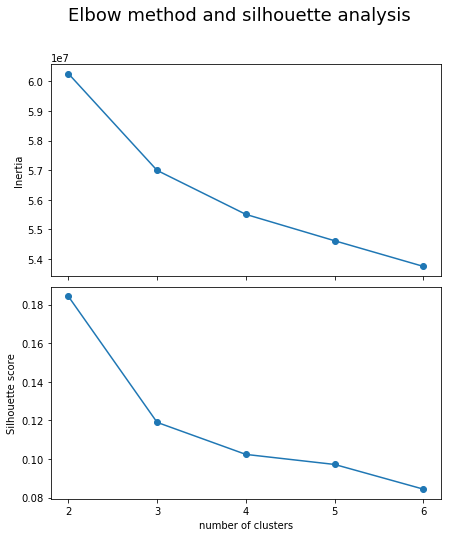

In [11]:
# Finding the best number of clusters - elbow and silhouette

features = list(X_azdias.columns)
    
if 'cluster' in features: features.remove('cluster')
        
# Elbow method for selecting number of cluster
ks = range(2, 7)
inertias = []
silhouette = []

for i in ks:
    model = KMeans(n_clusters=i)
    model.fit_predict(X_standard)
    inertias.append(model.inertia_)
    silhouette.append(silhouette_score(X_standard, model.labels_, sample_size=15000))


# Plots

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(7, 8))

fig.suptitle('Elbow method and silhouette analysis', fontsize=18)
fig.subplots_adjust(hspace=0.05)

# Elbow - decrease in inertia
ax1.plot(ks, inertias, '-o')
#ax1.set_title('Descrease in inertia', fontsize=14)
#ax1.set_xlabel('number of clusters')
ax1.set_ylabel('Inertia')
#ax1.set_title()

# Silhouette score
ax2.plot(ks, silhouette, '-o')
#ax2.set_title('Silhouette score',fontsize=14)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Silhouette score')
#ax2.set_title('Silhouette analysis')
ax2.set_xticks(ks)

plt.show();

In [13]:
# Create a KMeans instance with 3 clusters and fit German population data
n_clusters = 3

print('Number of clusters defined:', n_clusters)
model = KMeans(n_clusters=n_clusters, random_state=82)
labels = model.fit_predict(X_standard)

# Creating a data frame with original features values and cluster labels
clusters = X_azdias
clusters['cluster'] = labels

print('Frequency by cluster'.upper())
freq_pop = pd.concat([clusters['cluster'].value_counts(), round(clusters['cluster'].value_counts(normalize=True),4)], axis=1)
freq_pop.index.name = 'Cluster'
freq_pop.columns = ['n', '%']
print(freq_pop)

Number of clusters defined: 3
FREQUENCY BY CLUSTER
             n       %
Cluster               
2        79291  0.4448
0        69168  0.3881
1        29785  0.1671


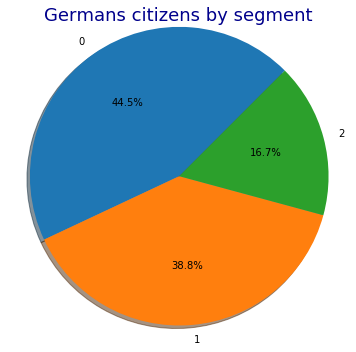

In [17]:
# Visualizing distribution of German citizens by cluster
plt.subplots(figsize=(6,6))
plt.pie(freq_pop['n'], autopct='%1.1f%%',shadow=True, startangle=45, labels=['0','1','2'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Germans citizens by segment',color='darkblue', fontsize=18, verticalalignment='top');

### 1.2 Understanding clusters' profiles

#### a. Classification tree

In [18]:
# Creating a classification tree to understand which features are relevant for defining the clusters
X = clusters.drop('cluster', axis=1) 
y = clusters['cluster']

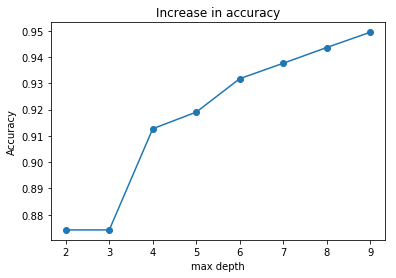

In [19]:
depths = range(2, 10)
accuracies = []

for d in depths:

    # Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=d, random_state=82)
    clf.fit(X, y)
    
    # Compute test set accuracy
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    accuracies.append(acc)
    #print("Train set accuracy: {:.2f}".format(acc))

# Accuracy vs tree depth
plt.plot(depths, accuracies, '-o')
plt.title('Increase in accuracy')
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.show();

In [22]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=9, random_state=82)
clf.fit(X, y)

# Compute test set accuracy
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Train set accuracy: {:.2f}".format(acc))

Train set accuracy: 0.95


In [23]:
# Finding the important features for defining clusters
feat_imp = pd.DataFrame({'Feature':X.columns,'Importance':clf.feature_importances_})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print('Number of features used as predictors:', feat_imp.shape[0], '\n')

feat_imp_top10 = feat_imp.head(10)
print('Top 10 most relevant')
feat_imp_top10

Number of features used as predictors: 394 

Top 10 most relevant


,Feature,Importance
0,KBA05_MOD4,0.380586
1,MOBI_RASTER,0.365701
2,LP_STATUS_FEIN,0.076829
3,KBA13_BAUMAX,0.050750
4,KBA13_ANTG3,0.022474
5,D19_GESAMT_DATUM,0.015910
6,VK_DISTANZ,0.011617
7,CAMEO_DEUG_2015,0.011352
8,D19_KONSUMTYP_MAX,0.008591
9,MOBI_REGIO,0.008348


#### b. Exploratory data analysis

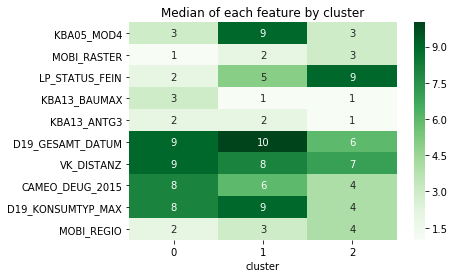


 DISTRIBUITION OF THE FEATURES BY CLUSTER


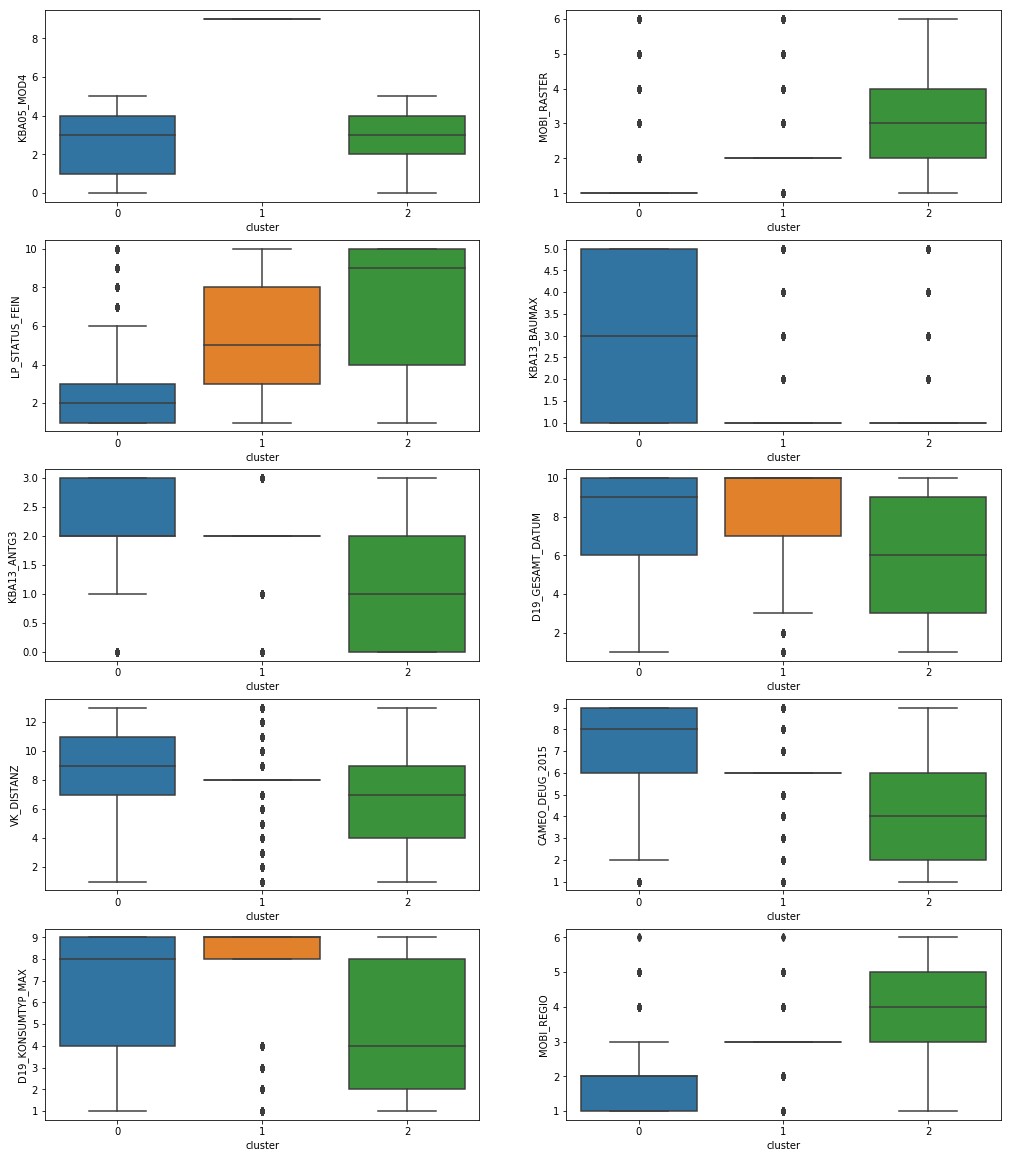

In [24]:
# Selecting relevant featues
features = feat_imp_top10['Feature'][:]

# Comparing clusters medians
sns.heatmap(clusters.groupby('cluster')[features].median().T, annot=True, cmap='Greens')
plt.title('Median of each feature by cluster')
plt.show();

# Features' distribuition by cluster
print('\n', 'Distribuition of the features by cluster'.upper())
plt.subplots(figsize=(14,16))
plt.tight_layout()

i=0
n_rows = np.ceil(len(features)/2)

for var in features:
    plt.subplot(n_rows,2,i+1)
    sns.boxplot(x='cluster', y=var, data=clusters)
    i+=1

plt.show();

In [25]:
# Descriptive statistics by cluster
for feature in features:
    display(pd.crosstab(clusters['cluster'], clusters[feature], normalize='index'))

KBA05_MOD4,0.0,1.0,2.0,3.0,4.0,5.0,9.0
cluster,,,,,,,
0,0.117988,0.132258,0.203591,0.254005,0.160248,0.131911,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,0.024744,0.129901,0.223985,0.342233,0.190463,0.088673,0.0


MOBI_RASTER,1.0,2.0,3.0,4.0,5.0,6.0
cluster,,,,,,
0,0.822042,0.114909,0.044457,0.012520,0.004757,0.001316
1,0.133725,0.667148,0.048044,0.045459,0.070203,0.035421
2,0.127555,0.182543,0.256549,0.206404,0.175165,0.051784


LP_STATUS_FEIN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cluster,,,,,,,,,,
0,0.488376,0.258732,0.115617,0.056254,0.008371,0.017551,0.007619,0.007041,0.024751,0.015686
1,0.159678,0.075172,0.056539,0.052711,0.337250,0.028269,0.009434,0.037200,0.156992,0.086755
2,0.067019,0.045226,0.063563,0.142412,0.055580,0.052642,0.015349,0.029083,0.278808,0.250318


KBA13_BAUMAX,1.0,2.0,3.0,4.0,5.0
cluster,,,,,
0,0.270400,0.137405,0.151963,0.136262,0.303970
1,0.908410,0.020547,0.013900,0.013564,0.043579
2,0.930585,0.048908,0.008311,0.003254,0.008942


KBA13_ANTG3,0.0,1.0,2.0,3.0
cluster,,,,
0,0.014573,0.077174,0.429505,0.478747
1,0.081685,0.098976,0.768843,0.050495
2,0.297575,0.450076,0.241818,0.010531


D19_GESAMT_DATUM,1,2,3,4,5,6,7,8,9,10
cluster,,,,,,,,,,
0,0.045744,0.040929,0.023002,0.035074,0.082929,0.042910,0.043821,0.066866,0.139212,0.479514
1,0.058654,0.044250,0.024073,0.030149,0.055061,0.025516,0.020682,0.026960,0.053651,0.661004
2,0.128451,0.099040,0.054205,0.069831,0.142513,0.059401,0.045718,0.064787,0.105308,0.230745


VK_DISTANZ,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cluster,,,,,,,,,,,,,
0,0.019171,0.014472,0.044573,0.017595,0.021383,0.072852,0.090432,0.129251,0.138952,0.156257,0.130234,0.107796,0.057035
1,0.022092,0.009367,0.050764,0.014873,0.024509,0.058889,0.055464,0.555246,0.052678,0.057680,0.045996,0.037771,0.014672
2,0.089090,0.034468,0.122839,0.052957,0.071156,0.123091,0.110820,0.104489,0.082317,0.079845,0.070790,0.042779,0.015361


CAMEO_DEUG_2015,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
cluster,,,,,,,,,
0,0.010973,0.007171,0.025865,0.027802,0.057223,0.147091,0.135583,0.317575,0.270718
1,0.012456,0.042169,0.069935,0.051771,0.035656,0.678328,0.031526,0.028840,0.049320
2,0.077398,0.186856,0.169754,0.216809,0.077171,0.139360,0.066565,0.047609,0.018476


D19_KONSUMTYP_MAX,1,2,3,4,8,9
cluster,,,,,,
0,0.101637,0.065623,0.056529,0.067546,0.373670,0.334996
1,0.101763,0.050193,0.040289,0.056673,0.137821,0.613262
2,0.236761,0.154822,0.092684,0.109647,0.275138,0.130948


MOBI_REGIO,1.0,2.0,3.0,4.0,5.0,6.0
cluster,,,,,,
0,0.416031,0.338726,0.191808,0.041522,0.011855,0.000058
1,0.074568,0.009065,0.907134,0.003995,0.005137,0.000101
2,0.022449,0.069894,0.206467,0.336495,0.363938,0.000757


### 1.3 Arvato customers' profile vs Germans profile

In [28]:
# Scaling and applying defined clusters
X_customers_standard = scaler.transform(X_customers)
labels = model.predict(X_customers_standard)

# Creating a data frame with features values and cluster labels
clusters = X_customers
clusters['cluster'] = labels

print('Frequency by cluster'.upper())
freq_customers = pd.concat([clusters['cluster'].value_counts(), round(clusters['cluster'].value_counts(normalize=True),4)], axis=1)
freq_customers.index.name = 'Cluster'
freq_customers.columns = ['n', '%']
print(freq_customers)

FREQUENCY BY CLUSTER
              n       %
Cluster                
2        108518  0.5662
1         56913  0.2970
0         26221  0.1368


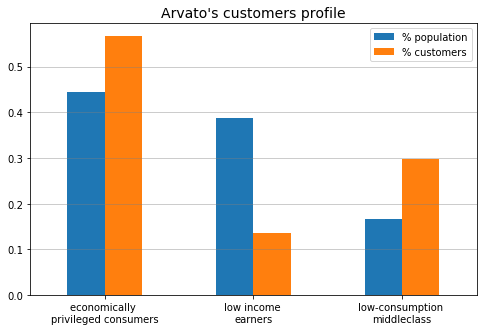

In [29]:
# Clusters distribution
clusters_comp = freq_pop.merge(freq_customers, left_index=True, right_index=True, suffixes=(' population', ' customers'))
clusters_comp[['% population','% customers']].plot(kind='bar', figsize=(8,5))
plt.title("Arvato's customers profile", fontsize=14)
plt.xticks([0,1,2],["economically \nprivileged consumers", "low income \nearners", "low-consumption \nmiddleclass"], rotation=0)
plt.xlabel('')
plt.grid(color='grey', alpha=0.5, axis='y')
plt.show();

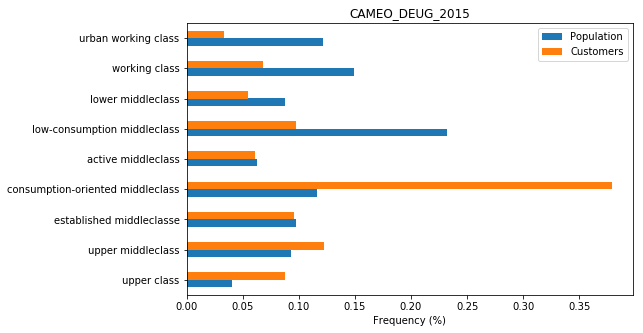

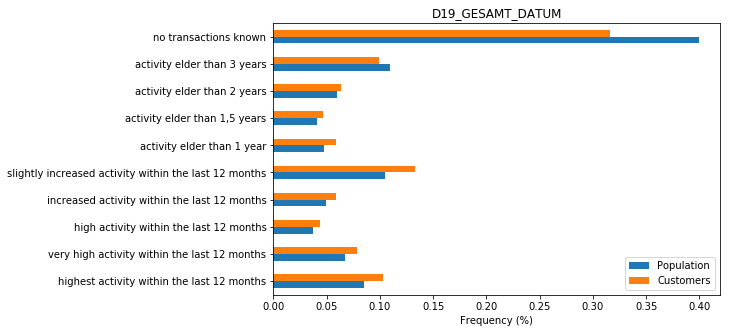

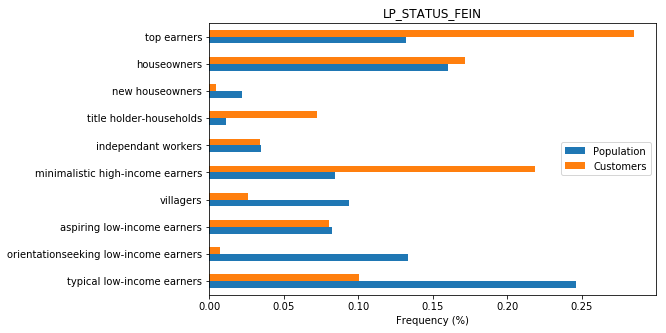

In [32]:
# Distribution of important features
dict_classes = {
    'CAMEO_DEUG_2015': ['upper class', 'upper middleclass', 'established middleclasse','consumption-oriented middleclass',
'active middleclass', 'low-consumption middleclass', 'lower middleclass', 'working class', 'urban working class'],
    
'D19_GESAMT_DATUM':['highest activity within the last 12 months','very high activity within the last 12 months',
'high activity within the last 12 months','increased activity within the last 12 months',
                    'slightly increased activity within the last 12 months',
'activity elder than 1 year','activity elder than 1,5 years','activity elder than 2 years',
                    'activity elder than 3 years','no transactions known'],

'LP_STATUS_FEIN':['typical low-income earners', 'orientationseeking low-income earners','aspiring low-income earners',
'villagers', 'minimalistic high-income earners', 'independant workers', 'title holder-households','new houseowners',
'houseowners','top earners']}

for feature in dict_classes.keys():
    freq_pop = X_azdias[feature].value_counts(normalize=True).to_frame()
    freq_pop.rename(columns={feature:'Population'}, inplace=True)

    freq_customers = customers[feature].value_counts(normalize=True).to_frame()
    freq_customers.rename(columns={feature:'Customers'}, inplace=True)

    comp = freq_pop.merge(freq_customers, left_index=True, right_index=True)
    comp.sort_index().plot(kind='barh', title=feature, figsize=(8,5))
    plt.xlabel("Frequency (%)")
    plt.yticks(range(len(comp)), dict_classes[feature])
    plt.show();